#First, we get some important libraries and import the data.

## **First, we get some important libraries and import the data.**

In [ ]:
import numpy as np
import pandas as pd
import tqdm.notebook as tq
import random
import math
import pickle
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn import svm, metrics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #For ploting
import torch    #Pytorch
import os
import torchvision.transforms as tt #To apply transformations to the dataset, augmenting it and transforming it to a tensor.
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder #Load dataset
from PIL import Image
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm



In [ ]:
# check device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
##########################################
# ACTION NEEDED! Change to a relevant path
##########################################
path = '/content/gdrive/MyDrive/Deep Learning/Data/Splits Pics'

In [ ]:
# Look into the data directory
data_dir = path
print(os.listdir(data_dir))
print(len(os.listdir(data_dir)))


['Left1_splitLeft.jpg', 'Left13_splitLeft.jpg', 'Left10_splitRight.jpg', 'Left12_splitLeft.jpg', 'Left1_splitRight.jpg', 'Left10_splitLeft.jpg', 'Left11_splitLeft.jpg', 'Left12_splitRight.jpg', 'Left13_splitRight.jpg', 'Left11_splitRight.jpg', 'Left20_splitRight.jpg', 'Left2_splitRight.jpg', 'Left14_splitRight.jpg', 'Left17_splitRight.jpg', 'Left18_splitRight.jpg', 'Left15_splitRight.jpg', 'Left14_splitLeft.jpg', 'Left18_splitLeft.jpg', 'Left17_splitLeft.jpg', 'Left16_splitLeft.jpg', 'Left15_splitLeft.jpg', 'Left20_splitLeft.jpg', 'Left16_splitRight.jpg', 'Left19_splitRight.jpg', 'Left2_splitLeft.jpg', 'Left19_splitLeft.jpg', 'Left23_splitLeft.jpg', 'Left24_splitLeft.jpg', 'Left24_splitRight.jpg', 'Left21_splitLeft.jpg', 'Left22_splitLeft.jpg', 'Left23_splitRight.jpg', 'Left21_splitRight.jpg', 'Left22_splitRight.jpg', 'Left29_splitRight.jpg', 'Left30_splitRight.jpg', 'Left27_splitLeft.jpg', 'Left25_splitLeft.jpg', 'Left3_splitRight.jpg', 'Left26_splitLeft.jpg', 'Left3_splitLeft.jpg', '

In [ ]:
train_data, val_data =train_test_split(os.listdir(data_dir), test_size=0.2, random_state=42)

## **Creating the datasets**

Now, we define the transformations to be applied to the images. This way we augment the dataset, allowing for better generalization and helping prevent overfitting.

In [ ]:
#Transformations aplied to test DS.
train_tf = tt.Compose([         
    #tt.ColorJitter(brightness=0.2),
    tt.Resize(size=(150,150)),
    #tt.RandomAffine(shear=(-5, 5)),
    tt.RandomHorizontalFlip(0.3),
    tt.RandomRotation(degrees=(-5, 5)),
    tt.ToTensor(),  
])

#Transformations aplied to test DS.
val_tf= tt.Compose([   
    tt.Resize(size=(150,150)),
    tt.ToTensor(),
])

In [ ]:
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

class HipFractureDataSet(Dataset):
    """Hip Fracture Data Set."""

    def __init__(self, root_dir, file_list, is_train=True, transform=None):

        self.root_dir = root_dir
        self.file_list = file_list
        self.is_train = is_train
        self.transform = transform

        self.targets = []
        for p in file_list:
          label = 0
          if p[:4] == "Left":
            if "splitLeft" in p:
              label = 1
          elif p[:5] == "Right":
            if "splitRight" in p:
              label = 1
          self.targets.append(label)

        self.classes = {0:"0", 1:"1"}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        p = self.file_list[idx] 
        img_name = os.path.join(self.root_dir, p)
        image = Image.open(img_name)
        label = self.targets[idx]

        if self.transform:
            image = self.transform(image)
            
        return image, torch.from_numpy(np.array(label))#, torch.FloatTensor()

define moco input images format

In [ ]:
from PIL import ImageFilter
import random

class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]


class GaussianBlur(object):
    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# MoCo v1's aug: the same as InstDisc https://arxiv.org/abs/1805.01978
augmentation = [
    transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
    transforms.RandomGrayscale(p=0.2),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
]

In [ ]:
train_tf = TwoCropsTransform(transforms.Compose(augmentation))

In [ ]:

train_dir = '/content/gdrive/MyDrive/Deep Learning/Data/train_data_dir'
train_data = os.listdir(train_dir)
train_ds = HipFractureDataSet(train_dir, train_data, transform=train_tf)

train_loader = torch.utils.data.DataLoader(
          train_ds, batch_size=8, shuffle=True,
          pin_memory=True)


memory_ds = HipFractureDataSet(train_dir, train_data, transform=val_tf)
memory_loader = torch.utils.data.DataLoader(
          memory_ds, batch_size=8, shuffle=False,
          pin_memory=True)



val_dir = '/content/gdrive/MyDrive/Deep Learning/Data/val_data_dir'
val_data = os.listdir(val_dir)

val_ds = HipFractureDataSet(val_dir, val_data, transform=val_tf)
val_loader = torch.utils.data.DataLoader(
          val_ds, batch_size=1, shuffle=False,
          pin_memory=True)



Getting the images.

Showing some information about the dataset.

In [ ]:
def ds_info(dataset):
    dataset_size=len(dataset)
    classes = dataset.classes
    num_classes = len(classes)
    
    #Initialize list
    count = []     
    for x in range(num_classes):
        count.append(0)
        
    #Count every label
    for x in range(dataset_size):
        count[dataset[x][1]]+=1
        
    print('Size of the dataset:' + str(dataset_size))
    print('Number of classes:' + str(num_classes))    
    print('Samples for every class:')
    
    #Print the count
    for x in range(num_classes):
        print(classes[x] + " : " + str(count[x]))


In [ ]:
ds_info(train_ds)
ds_info(val_ds)

Size of the dataset:155
Number of classes:2
Samples for every class:
0 : 77
1 : 78
Size of the dataset:39
Number of classes:2
Samples for every class:
0 : 20
1 : 19


Next let's separate the data in batches, so we can load them on the GPU later and pass them through the networks.

It's a good idea to visualize some of the samples to see if transformations make sense and aren’t too disruptive of the original data.



In [ ]:
from torchvision.utils import make_grid

In [ ]:
def show_batch(dl):
  fig, ax = plt.subplots(figsize=(15, 15))
  ax.set_xticks([]); ax.set_yticks([])
  images = []
  for img, labels in dl:
    images.append(img)
  torch_tensor = torch.from_numpy(np.array(images))
  x = make_grid(torch_tensor, nrow=12)
  ax.imshow(x.permute(1, 2, 0))
        

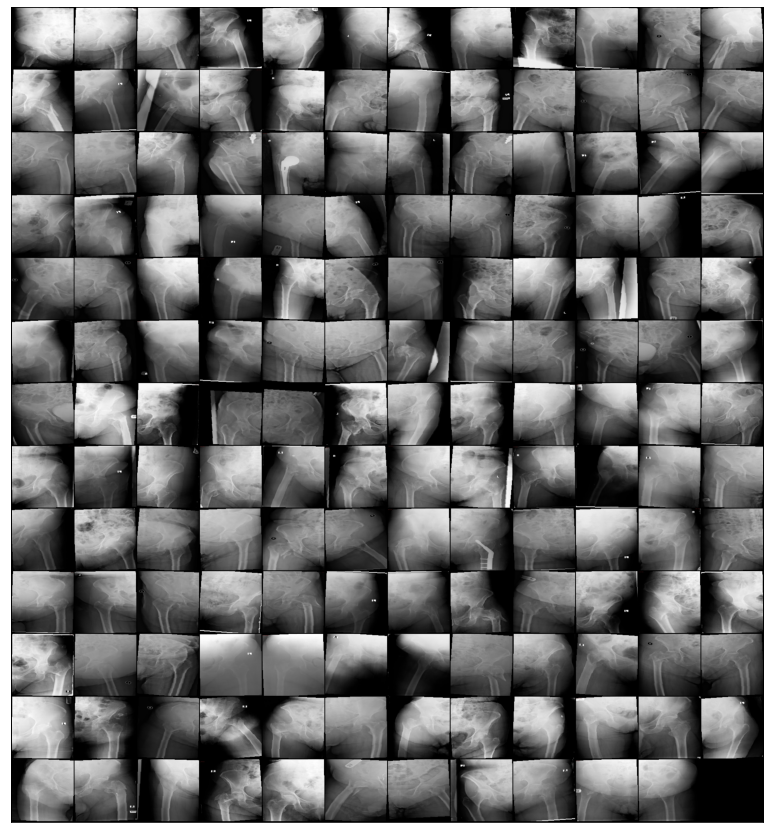

In [ ]:
show_batch(train_ds)

## **Creating the Networks**

For the first run we're going to create the base network class, this way we can define steps that are general for training and data handling that’s independent (to a certain degree) of the specific network architecture.

We create an accuracy function that counts the amount of correct predictions and divides it with the size of the batch. It gives us a metric of how good the network it's getting.

In [ ]:
import torchvision.models as models

https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb#scrollTo=M3INyoTC3-bf

define moco parameters 

In [ ]:
import argparse
parser = argparse.ArgumentParser(description='Train MoCo on CIFAR-10')

parser.add_argument('-a', '--arch', default='resnet18')

# lr: 0.06 for batch 512 (or 0.03 for batch 256)
parser.add_argument('--lr', '--learning-rate', default=0.006, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', action='store_true', help='use cosine lr schedule')

parser.add_argument('--batch-size', default=8, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')
# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int, help='feature dimension')
parser.add_argument('--moco-k', default=4096, type=int, help='queue size; number of negative keys')
parser.add_argument('--moco-m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--moco-t', default=0.1, type=float, help='softmax temperature')

parser.add_argument('--bn-splits', default=8, type=int, help='simulate multi-gpu behavior of BatchNorm in one gpu; 1 is SyncBatchNorm in multi-gpu')
parser.add_argument('--symmetric', action='store_true', help='use a symmetric loss function that backprops to both crops')

# knn monitor
parser.add_argument('--knn-k', default=3, type=int, help='k in kNN monitor')
parser.add_argument('--knn-t', default=0.1, type=float, help='softmax temperature in kNN monitor; could be different with moco-t')

# utils
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--results-dir', default='', type=str, metavar='PATH', help='path to cache (default: none)')
'''
args = parser.parse_args()  # running in command line
'''
args = parser.parse_args('')  # running in ipynb
# set command line arguments here when running in ipynb
args.epochs = 100
args.cos = True
args.schedule = []  # cos in use
args.symmetric = False

print(args)

Namespace(arch='resnet18', batch_size=8, bn_splits=8, cos=True, epochs=100, knn_k=3, knn_t=0.1, lr=0.006, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, results_dir='', resume='', schedule=[], symmetric=False, wd=0.0005)


In [ ]:
from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet
from tqdm import tqdm

# model architecture

In [ ]:
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var, 
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    def __init__(self, feature_dim=128, arch=None, bn_splits=1):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if isinstance(module, nn.MaxPool2d):
                continue
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten(1))
            self.net.append(module)

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

In [ ]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, T=0.1, arch='resnet18', bn_splits=1, symmetric=True):
        super(ModelMoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)

        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
        
        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss


## train moco model

In [ ]:
model_moco = ModelMoCo().cuda()

In [ ]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    adjust_learning_rate(optimizer, epoch, args)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for [im_1, im_2],_ in train_bar:
        im_1, im_2 = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True)

        if im_1.shape[0] != 8:
          continue

        loss = net(im_1, im_2)
        
        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(epoch, args.epochs, optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch, args):
    net.eval()
    classes = len(memory_data_loader.dataset.classes)
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        y_pred = []
        y_labels = []
        for data, target in test_bar:
            target = target.cuda(non_blocking=True)
            data = data.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)
            
            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, args.knn_k, args.knn_t)

            y_pred.append(pred_labels)
            y_labels.append(target)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, args.epochs, total_top1 / total_num * 100))
            

    return total_top1 / total_num * 100, y_pred, y_labels

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

In [ ]:
# define optimizer
optimizer = torch.optim.SGD(model_moco.parameters(), lr=args.lr, weight_decay=args.wd, momentum=0.9)

results = {'train_loss': [], 'test_acc@1': []}
# training loop
for epoch in range(0, args.epochs):
    train_loss = train(model_moco, train_loader, optimizer, epoch, args)
    results['train_loss'].append(train_loss)
    if epoch % 3 == 0:
      test_acc_1, _, _ = test(model_moco.encoder_q, memory_loader, val_loader, epoch, args)
    #results['test_acc@1'].append(test_acc_1)
    # save statistics
    #data_frame = pd.DataFrame(data=results, index=range(epoch_start, epoch + 1))
    #data_frame.to_csv(args.results_dir + '/log.csv', index_label='epoch')
    # save model
    #torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, args.results_dir + '/model_last.pth')

Train Epoch: [5/100], lr: 0.005963, Loss: 9.2390: 100%|██████████| 20/20 [00:24<00:00,  1.22s/it]


Namespace(arch='resnet18', batch_size=8, bn_splits=8, cos=True, epochs=100, knn_k=3, knn_t=0.1, lr=0.006, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, results_dir='', resume='', schedule=[], symmetric=False, wd=0.0005)

# evaluate moco

In [ ]:
def parse_result(targets, y_pred):
  labels = []
  for t in targets:
    labels.append(t.cpu().numpy())

  labels = np.array(labels)

  predictions = []
  for t in y_pred:
    predictions.append(t.cpu().numpy())

  predictions = np.argmax(predictions, axis=-1)

  return labels, predictions

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(cm, title):

  ax = sns.heatmap(cm, annot=True, cmap='Blues')
  ax.set_title(title);
  ax.set_xlabel('\nPredicted Category')
  ax.set_ylabel('Actual Category ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['no_fracture','fracture'])
  ax.yaxis.set_ticklabels(['no_fracture','fracture'])

  plt.show()


def get_confusion_matrix(name_model, labels, prediction):

  title = f"{name_model}_confusion_matrix"
  cm = confusion_matrix(labels, prediction)
  plot_cm(cm, title)


# find optimale knn value for problame 

since moco prediction derived from knn classifier of trained fetures, we need to preform grid serch in order to to located optimal k value

In [ ]:
test_results = []

for k in range(1,25):
  args.knn_k = k
  test_acc_1,  y_pred, target = test(model_moco.encoder_q, memory_loader, val_loader, 0, args)
  test_results.append(test_acc_1)


Test Epoch: [0/100] Acc@1:61.54%: 100%|██████████| 39/39 [00:02<00:00, 16.69it/s]


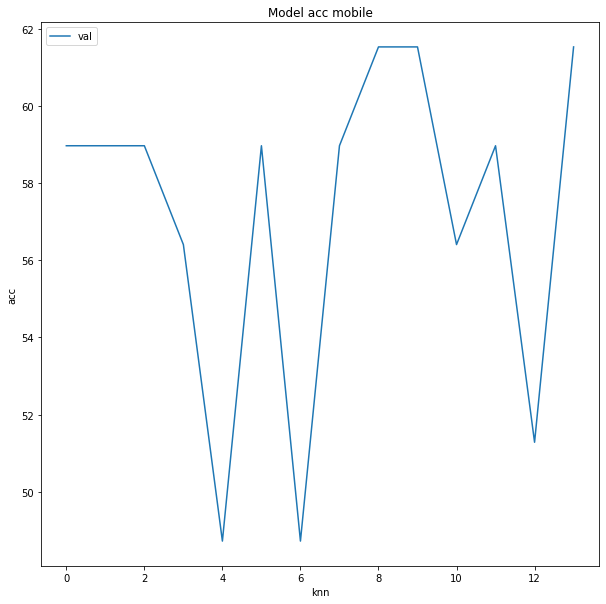

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(test_results)
plt.title(f"Model acc mobile")
plt.ylabel('acc')
plt.xlabel('knn')
plt.legend(['val'], loc='upper left')
plt.show()

since k==9, is optimal value, 
we will test its outcome 

In [ ]:
k = 9
args.knn_k = k
test_acc_1,  y_pred, target = test(model_moco.encoder_q, memory_loader, val_loader, 0, args)
labels, predictions = parse_result(target, y_pred)

Test Epoch: [0/100] Acc@1:61.54%: 100%|██████████| 39/39 [00:02<00:00, 17.31it/s]


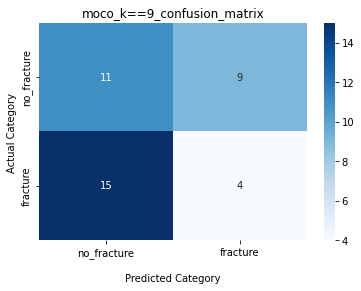

In [ ]:
get_confusion_matrix(f"moco_k={k}", labels, predictions)